# I.I Imports

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import sklearn, imblearn, lightgbm, pandas, numpy
print("Environment ready!")
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("lightgbm:", lightgbm.__version__)
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)


Environment ready!
scikit-learn: 1.4.2
imbalanced-learn: 0.12.3
lightgbm: 4.5.0
pandas: 2.3.3
numpy: 1.26.4


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
from matplotlib import pyplot as plt
import seaborn as sns

# Core ML
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline


# Imputation (MICE-like)
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import SimpleImputer, IterativeImputer

# Imbalanced learning
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


from lightgbm import LGBMClassifier


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

%matplotlib inline
%config IPCompleter.greedy=True
warnings.filterwarnings('ignore')

In [4]:
from challenge.data.ingest import load_data
from challenge.data.preprocess import preprocess_test_data
from challenge.modelling.train_eval import cv_cost, evaluate_on_test

# I.II Data Audit and Cleaning

In [5]:
Path().mkdir(exist_ok=True, parents=True)

In [6]:
Path.cwd()

PosixPath('/Users/berkcalisir/School&Career/school-docs/Challenge@Stellantis/Challenge-Stellantis---CarGuardians/src')

When loading we replace "na" with null values.

In [7]:
train, test = load_data('./dataset/aps_failure_training_set.csv', './dataset/aps_failure_test_set.csv')

Train shape: (60000, 171), Test shape: (16000, 171)


In [8]:
train.describe()

aa_000        ab_000        ac_000        ad_000        ae_000  \
count  6.000000e+04  13671.000000  5.666500e+04  4.513900e+04  57500.000000   
mean   5.933650e+04      0.713189  3.560143e+08  1.906206e+05      6.819130   
std    1.454301e+05      3.478962  7.948749e+08  4.040441e+07    161.543373   
min    0.000000e+00      0.000000  0.000000e+00  0.000000e+00      0.000000   
25%    8.340000e+02      0.000000  1.600000e+01  2.400000e+01      0.000000   
50%    3.077600e+04      0.000000  1.520000e+02  1.260000e+02      0.000000   
75%    4.866800e+04      0.000000  9.640000e+02  4.300000e+02      0.000000   
max    2.746564e+06    204.000000  2.130707e+09  8.584298e+09  21050.000000   

             af_000        ag_000        ag_001        ag_002        ag_003  \
count  57500.000000  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04   
mean      11.006817  2.216364e+02  9.757223e+02  8.606015e+03  8.859128e+04   
std      209.792592  2.047846e+04  3.420053e+04  1.503220e+05  7.617312e+05   
min        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%        0.000000  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    20070.000000  3.376892e+06  4.109372e+06  1.055286e+07  6.340207e+07   

       ...        ee_002        ee_003        ee_004        ee_005  \
count  ...  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04   
mean   ...  4.454897e+05  2.111264e+05  4.457343e+05  3.939462e+05   
std    ...  1.155540e+06  5.433188e+05  1.168314e+06  1.121044e+06   
min    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    ...  2.936000e+03  1.166000e+03  2.700000e+03  3.584000e+03   
50%    ...  2.337960e+05  1.120860e+05  2.215180e+05  1.899880e+05   
75%    ...  4.383960e+05  2.182320e+05  4.666140e+05  4.032220e+05   
max    ...  7.793393e+07  3.775839e+07  9.715238e+07  5.743524e+07   

             ee_006        ee_007        ee_008        ee_009        ef_000  \
count  5.932900e+04  5.932900e+04  5.932900e+04  5.932900e+04  57276.000000   
mean   3.330582e+05  3.462714e+05  1.387300e+05  8.388915e+03      0.090579   
std    1.069160e+06  1.728056e+06  4.495100e+05  4.747043e+04      4.368855   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00      0.000000   
25%    5.120000e+02  1.100000e+02  0.000000e+00  0.000000e+00      0.000000   
50%    9.243200e+04  4.109800e+04  3.812000e+03  0.000000e+00      0.000000   
75%    2.750940e+05  1.678140e+05  1.397240e+05  2.028000e+03      0.000000   
max    3.160781e+07  1.195801e+08  1.926740e+07  3.810078e+06    482.000000   

             eg_000  
count  57277.000000  
mean       0.212756  
std        8.830641  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max     1146.000000  

[8 rows x 170 columns]

In [9]:
train.head()

class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2   neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3   neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4   neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   
2     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0  158022.0   
3     0.0  ...      240.0      46.0      58.0      44.0      10.0       0.0   
4     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0  311560.0   

     ee_008  ee_009  ef_000  eg_000  
0   73224.0     0.0     0.0     0.0  
1   97576.0  1500.0     0.0     0.0  
2   95128.0   514.0     0.0     0.0  
3       0.0     0.0     4.0    32.0  
4  433954.0  1218.0     0.0     0.0  

[5 rows x 171 columns]

The dataset has 171 anonymized attributes, where:

- Most columns are continuous numerical sensor readings or counters (e.g., aa_000, bt_000, ci_000, etc.).

- A subset of columns are histogram variables, typically representing binned distributions of sensor activity under varying operating conditions.

In total, there are 7 such histogram families in the APS dataset, corresponding to different subsystems (e.g., compressor, reservoir, valve, etc.).

Treating each bin (ee_000–ee_009) as a separate feature captures the shape of the sensor distribution (e.g., normal vs skewed operation). However, these bins are correlated, since they sum to 1 (or a constant total frequency count).

- Keep all bins if using tree-based models (RF, LGBM) — they handle redundancy well.

- Apply feature engineering for compactness:

    - Compute mean bin index weighted by frequency (center of mass)

    - Compute standard deviation or entropy of the histogram

    - Compute ratios between early vs late bins (to detect drifts or abnormal load)

In [10]:
def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

def inspect_duplications(df):
    num_duplicated = len(df[df.duplicated()])
    print(f'STATUS: There are/is {num_duplicated} duplicated rows')
def inspect_null_columns(df, df_name, target=None):
    if df.isnull().values.any() ==False:
        print(f'STATUS: There is NO ANY null value in dataframe "{df_name}"')
    else:
        if target!=None:
            if (df[target].isna().any()):
                print("STATUS: The target class has null values.")
            else:
                print("STATUS: The target class has no null values.")
        columns = df.columns[df.isna().any()].tolist()
        temp = {}
        for column in columns:
            temp[column] = (len(df) - df[column].count())
        print(f"STATUS: {len(columns)} columns with null values, over a total of {len(df.columns)}")
        return pd.DataFrame(temp, index=[0]).T #temp

train.replace("na", np.nan, inplace=True)
shape(train, 'train_data')
nulls = inspect_null_columns(train,'train','class')
inspect_duplications(train)
train.head()

STATUS: Dimension of "train_data" = (60000, 171)
STATUS: The target class has no null values.
STATUS: 169 columns with null values, over a total of 171
STATUS: There are/is 0 duplicated rows


class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2   neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3   neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4   neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   
2     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0  158022.0   
3     0.0  ...      240.0      46.0      58.0      44.0      10.0       0.0   
4     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0  311560.0   

     ee_008  ee_009  ef_000  eg_000  
0   73224.0     0.0     0.0     0.0  
1   97576.0  1500.0     0.0     0.0  
2   95128.0   514.0     0.0     0.0  
3       0.0     0.0     4.0    32.0  
4  433954.0  1218.0     0.0     0.0  

[5 rows x 171 columns]

In [11]:
train["class"] = train["class"].replace({"neg":0, "pos":1})
test["class"]  = test["class"].replace({"neg":0, "pos":1})

In [12]:
def drop_single_valued(df):
    non_const = df.loc[:, df.nunique(dropna=False) >= 1]
    removed = [c for c in df.columns if c not in non_const.columns]
    return non_const, removed

In [13]:
train, removed_single_value = drop_single_valued(train)
print(f"Removed single-valued features: {removed_single_value}")

Removed single-valued features: []


In [14]:
# summarize missing ratio visually (heatmap or null % histogram).
nulls_df = nulls.rename(columns = {0:'null values per column'}).sort_values(by = 'null values per column', ascending=False)
nulls_df['percentage of nulls'] = (nulls_df['null values per column'])/len(train)
display(nulls_df)

null values per column  percentage of nulls
br_000                   49264             0.821067
bq_000                   48722             0.812033
bp_000                   47740             0.795667
bo_000                   46333             0.772217
ab_000                   46329             0.772150
...                        ...                  ...
by_000                     473             0.007883
ci_000                     338             0.005633
cj_000                     338             0.005633
ck_000                     338             0.005633
bt_000                     167             0.002783

[169 rows x 2 columns]

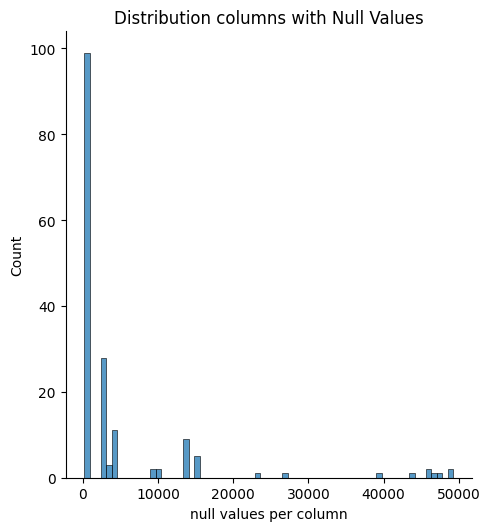

In [15]:
def vis_dist(df, col, lim=False, max_range=None):
    variable = df[col].values
    ax = sns.displot(variable)
    plt.title(f'Distribution columns with Null Values')
    plt.xlabel(f'{col}')
    if lim:
        plt.xlim(0, max_range)
    return plt.show()
vis_dist(nulls_df, 'null values per column')

In [16]:
def missing_rates(df, exclude_cols=None):
    exclude_cols = set(exclude_cols or [])
    rates = (df.isna().sum() / len(df)).rename("missing_rate").to_frame()
    return rates.loc[[c for c in df.columns if c not in exclude_cols]]

In [17]:
rates = missing_rates(train, exclude_cols=["class"])
# Buckets
high_na_feats   = rates.index[rates["missing_rate"] > 0.70].tolist()
lt4_feats       = rates.index[(rates["missing_rate"] > 0.0) & (rates["missing_rate"] < 0.04)].tolist()
med_4_15_feats  = rates.index[(rates["missing_rate"] >= 0.04) & (rates["missing_rate"] <= 0.15)].tolist()
mice_15_70_feats= rates.index[(rates["missing_rate"] > 0.15) & (rates["missing_rate"] <= 0.70)].tolist()

print(f">70% missing (drop): {len(high_na_feats)}")
print(f"<4% missing (drop rows, train only): {len(lt4_feats)}")
print(f"4–15% missing (median impute): {len(med_4_15_feats)}")
print(f"15–70% missing (MICE): {len(mice_15_70_feats)}")

>70% missing (drop): 7
<4% missing (drop rows, train only): 99
4–15% missing (median impute): 42
15–70% missing (MICE): 21


In [18]:
# We’ll keep a copy of the “removed_features” for test preprocessing
removed_features = high_na_feats.copy()

In [19]:
len(lt4_feats)

99

# I.III Preprocessing

In [20]:
# TRAIN preprocessing (drop feats, then row-drop for <4%, median-impute for 4–15%, MICE for 15–70%)
train_work = train.drop(columns=removed_features)

# a) drop rows with NA in lt4_feats (train only)
if lt4_feats:
    before = len(train_work)
    train_work = train_work.dropna(subset=[c for c in lt4_feats if c in train_work.columns])
    print(f"Dropped {before - len(train_work)} rows due to <4% features")

# b) median imputer for 4–15%
MEDIAN_imputer = None
if med_4_15_feats:
    MEDIAN_imputer = SimpleImputer(strategy="median")
    train_work[med_4_15_feats] = MEDIAN_imputer.fit_transform(train_work[med_4_15_feats])

# c) MICE (IterativeImputer with Ridge) for 15–70%
MICE_imputer = None
if mice_15_70_feats:
    MICE_imputer = IterativeImputer(
        estimator=Ridge(alpha=1.0, random_state=RANDOM_STATE),
        max_iter=10,
        random_state=RANDOM_STATE,
        sample_posterior=False
    )
    train_work[mice_15_70_feats] = MICE_imputer.fit_transform(train_work[mice_15_70_feats])


Dropped 1873 rows due to <4% features


In [21]:
# Split X/y after preprocessing
X_all = train_work.drop(columns=["class"])
y_all = train_work["class"].values

In [22]:
# TEST preprocessing function (
def preprocess_test_data(x, na_features, median_features, imputer_median, imputer_mice):
    x = x.copy()
    x["class"] = x["class"].replace(["neg","pos"], [0,1])
    y = x["class"].values
    x = x.drop(columns=["class"])

    # Drop features with >70% missing (same set from train)
    x = x.drop(columns=[f for f in na_features if f in x.columns])

    # Apply median imputer on the defined subset
    if median_features:
        present = [c for c in median_features if c in x.columns]
        if present:
            x[present] = imputer_median.transform(x[present])

    # Apply MICE imputer on the defined subset
    if imputer_mice is not None:
        # Only transform columns present in training order
        cols = x.columns
        # We fitted imputer on a subset (mice_15_70_feats). We must apply only to those present
        to_mice = [c for c in mice_15_70_feats if c in cols]
        if to_mice:
            x[to_mice] = imputer_mice.transform(x[to_mice])

    return x, y

In [23]:
# Prepare test (no row dropping!)
x_test_pp, y_test = preprocess_test_data(
    test,
    removed_features,
    med_4_15_feats,
    MEDIAN_imputer,
    MICE_imputer
)
print("Shape of Test data:", x_test_pp.shape)

# Align test columns to train columns (in case of column order/availability)
x_test_pp = x_test_pp.reindex(columns=X_all.columns, fill_value=0)

Shape of Test data: (16000, 163)


# I.IV Histogram Families

We end up removing 7 columns

In [24]:
def histogram_families(columns):
    fam = {}
    for c in columns:
        if "_" in c and c[-3:].isdigit() and len(c.split("_")[-1]) == 3:
            prefix = c.split("_")[0]
            fam.setdefault(prefix, []).append(c)
    # keep only families that look like 10 bins (xxx_000..xxx_009)
    return {k: sorted(v) for k, v in fam.items() if len(v) >= 10}

hist_fams = histogram_families(X_all.columns)
# Optionally trim to the canonical 7 (if you’ve pre-verified): ag, ay, az, ba, cn, cs, ee
keep_keys = {"ag","ay","az","ba","cn","cs","ee"}
hist_fams = {k: v for k, v in hist_fams.items() if k in keep_keys}
print({k: (len(v), v[:3], "...") for k,v in hist_fams.items()})


{'ag': (10, ['ag_000', 'ag_001', 'ag_002'], '...'), 'ay': (10, ['ay_000', 'ay_001', 'ay_002'], '...'), 'az': (10, ['az_000', 'az_001', 'az_002'], '...'), 'ba': (10, ['ba_000', 'ba_001', 'ba_002'], '...'), 'cn': (10, ['cn_000', 'cn_001', 'cn_002'], '...'), 'cs': (10, ['cs_000', 'cs_001', 'cs_002'], '...'), 'ee': (10, ['ee_000', 'ee_001', 'ee_002'], '...')}


# I.V Feature selection hooks (RFE on hist-only & on non-hist)

In [25]:
# Feature selection hooks (RFE on hist-only & on non-hist)
# Define hist-only and numeric-only splits for RFE inspection
hist_cols = sorted({c for cols in hist_fams.values() for c in cols})
non_hist_cols = [c for c in X_all.columns if c not in hist_cols]

In [26]:
# RFE to pick top 15 hist features (on TRAIN only)
def rfe_top_features(X, y, cols, n_features=15):
    if len(cols) <= n_features:
        return cols
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=0.1)
    rfe.fit(X[cols], y)
    return list(pd.Index(cols)[rfe.support_])

top15_hist = rfe_top_features(X_all, y_all, hist_cols, n_features=15) if hist_cols else []
top15_num  = rfe_top_features(X_all, y_all, non_hist_cols, n_features=15) if non_hist_cols else []
print("Top15 histogram features:", top15_hist)
print("Top15 numerical features:", top15_num)

# support/correlation matrix for the selected features

Top15 histogram features: ['ag_001', 'ag_002', 'ag_003', 'ag_006', 'ay_005', 'ay_006', 'ay_008', 'az_000', 'ba_000', 'cn_000', 'cn_004', 'cs_002', 'cs_004', 'ee_000', 'ee_005']
Top15 numerical features: ['aa_000', 'al_000', 'am_0', 'ap_000', 'aq_000', 'bb_000', 'bj_000', 'bt_000', 'bu_000', 'bv_000', 'by_000', 'ci_000', 'ck_000', 'cq_000', 'dn_000']


# I.VI Plot PDFs/CDFs/Boxplots for top15 — stubs:


In [27]:
train_eda = train.drop(columns=removed_features)

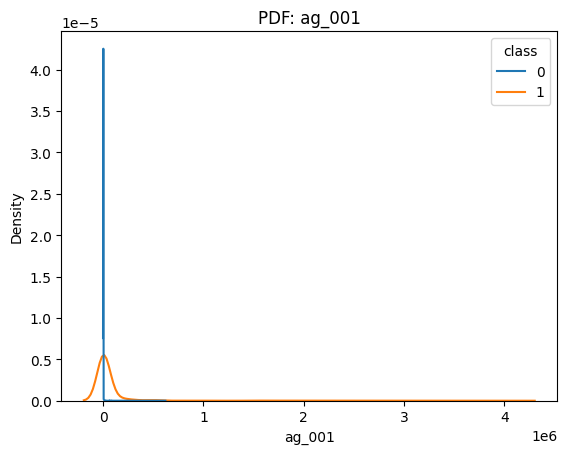

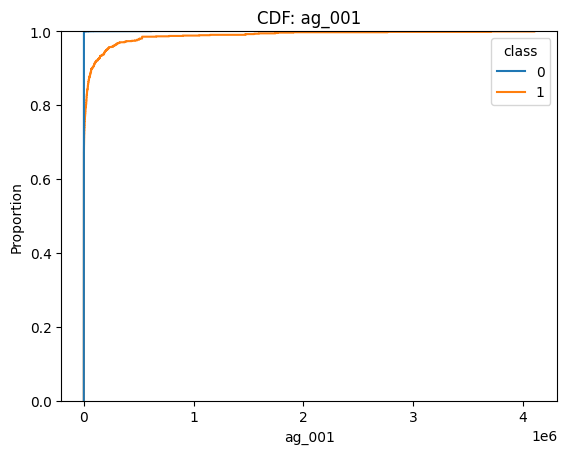

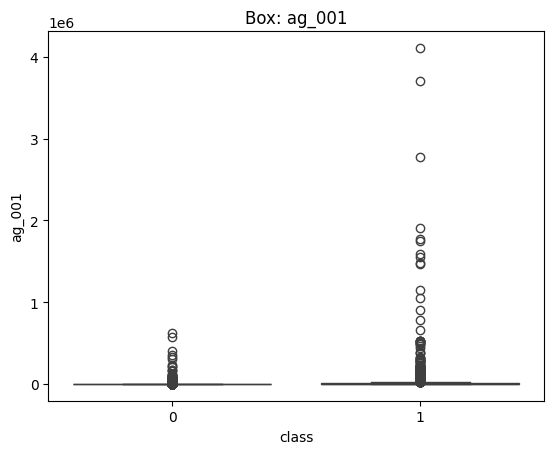

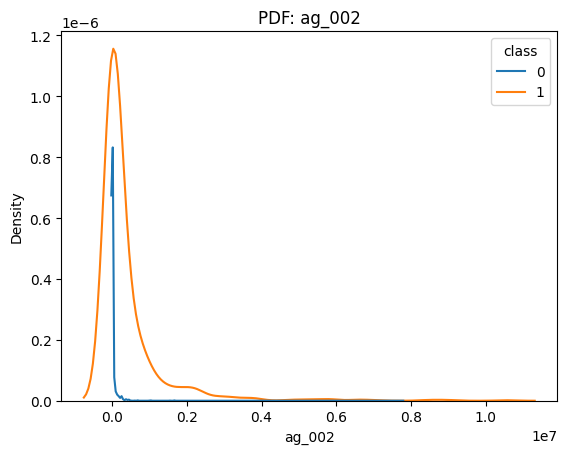

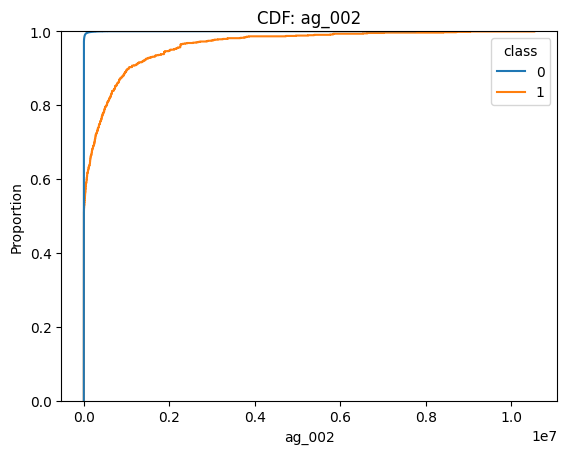

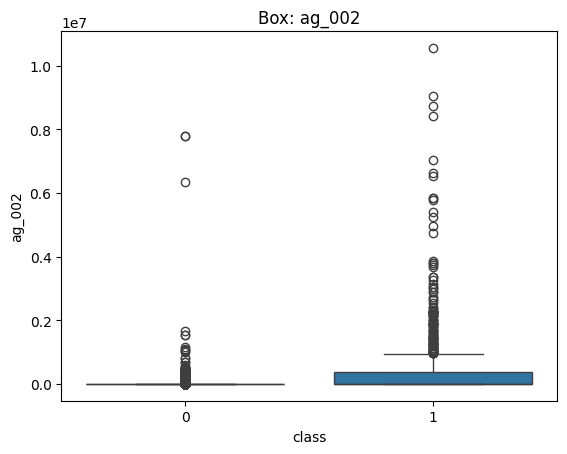

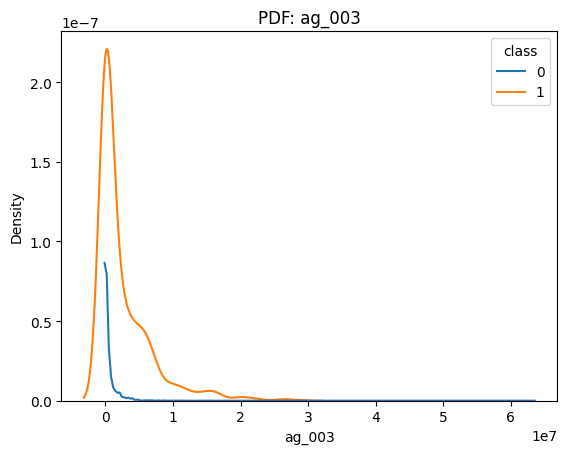

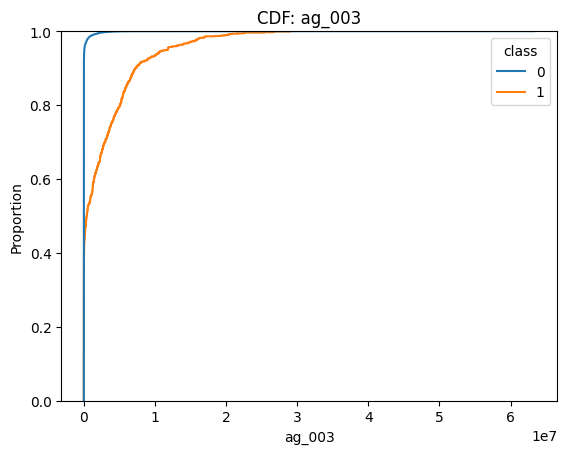

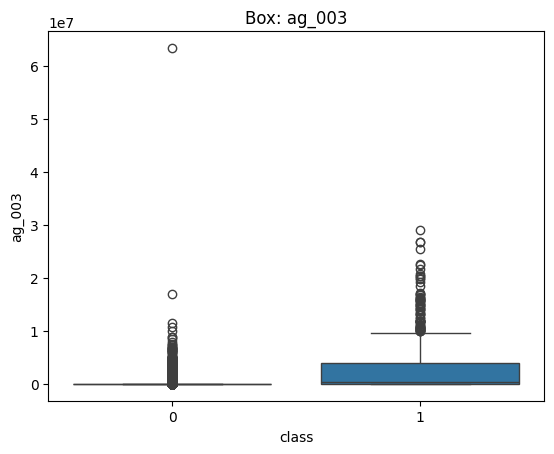

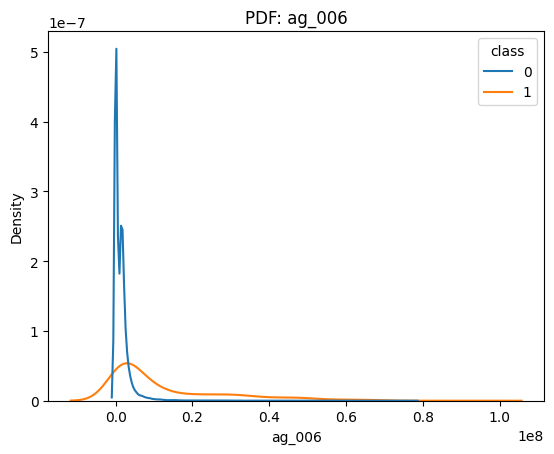

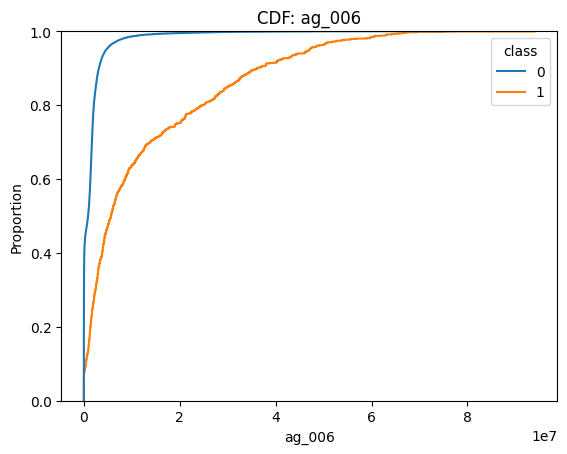

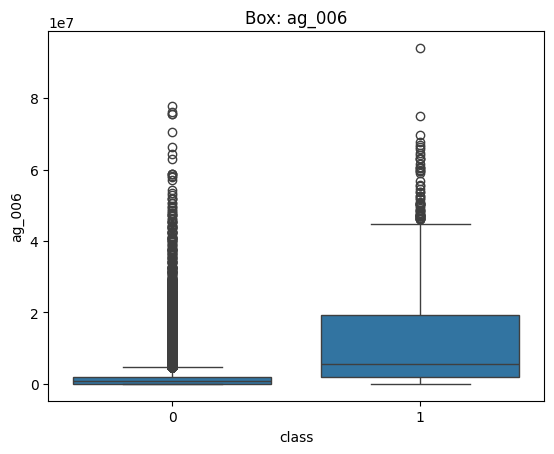

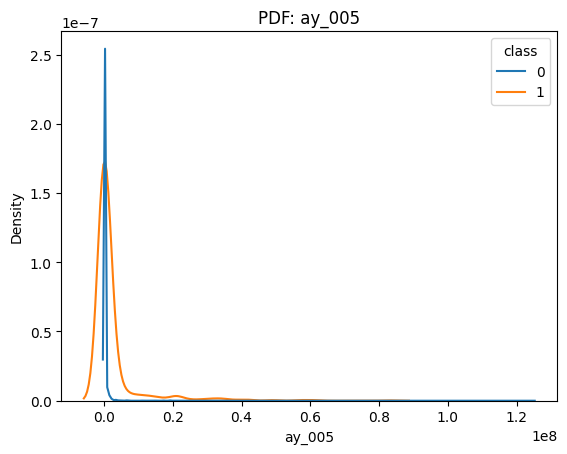

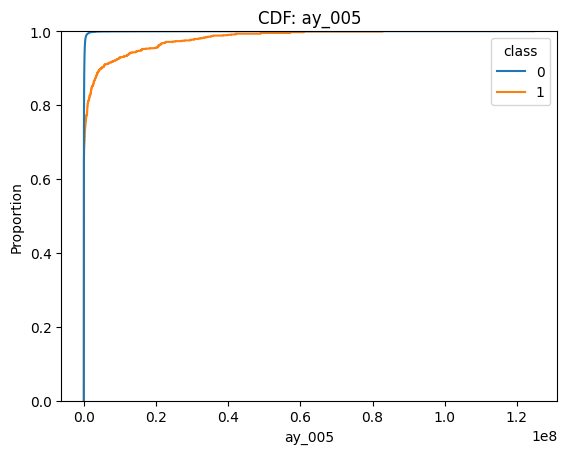

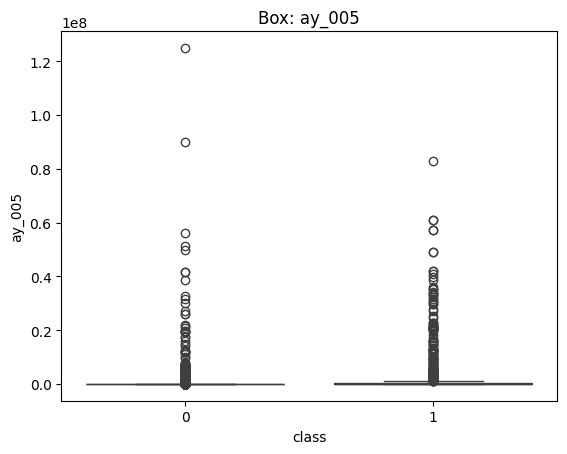

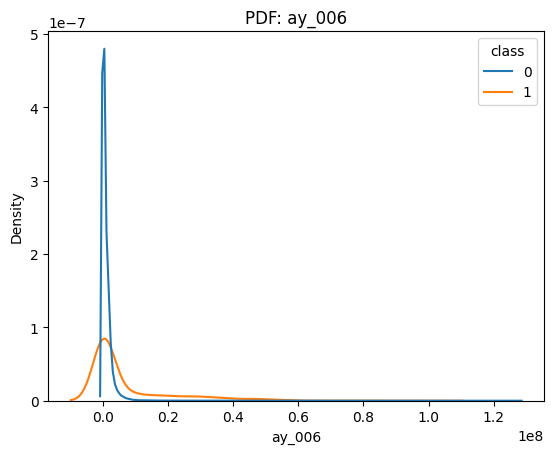

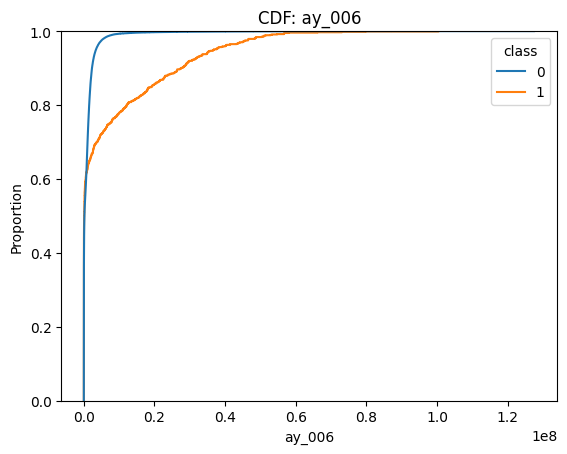

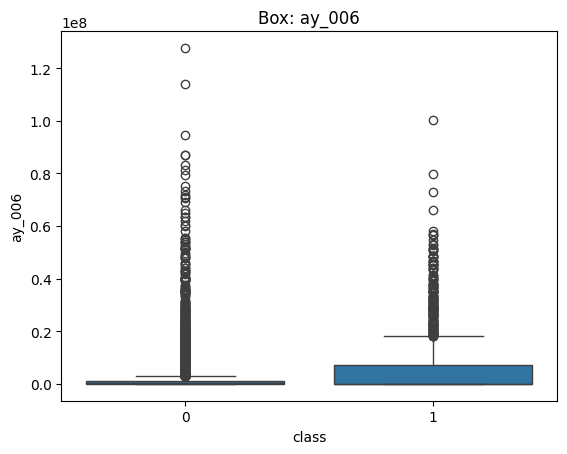

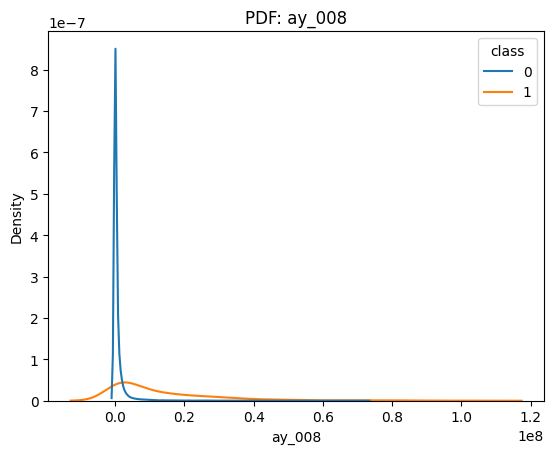

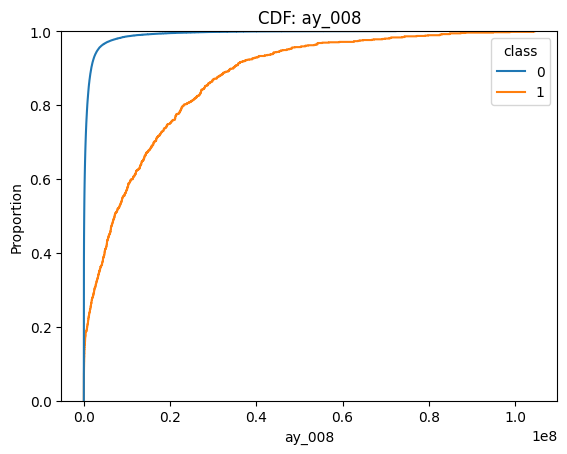

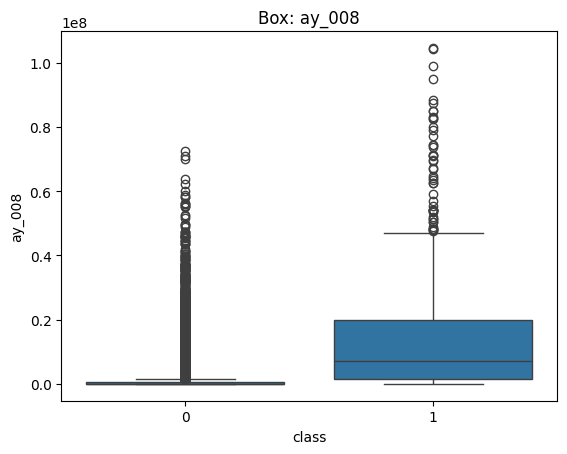

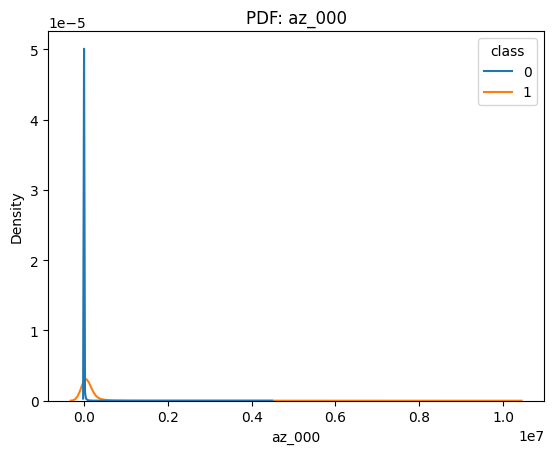

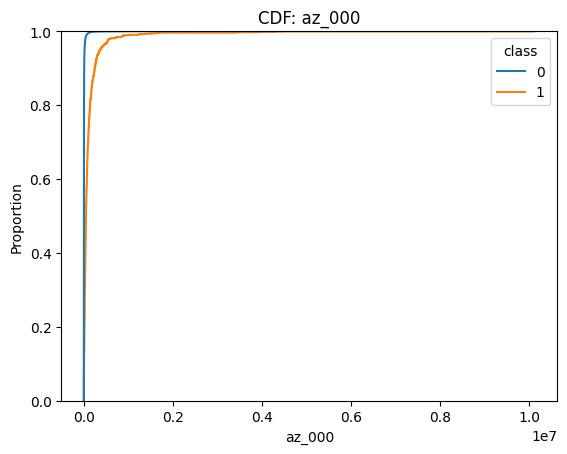

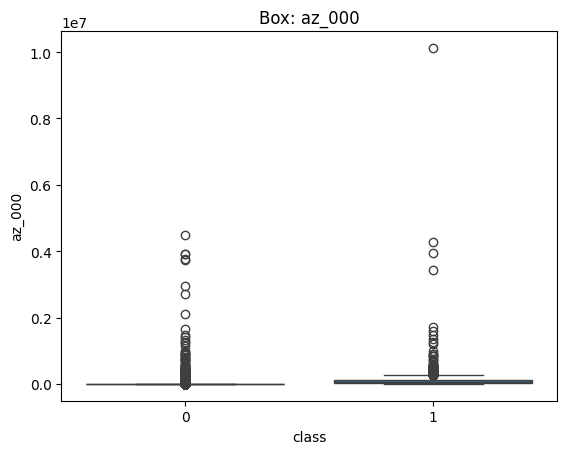

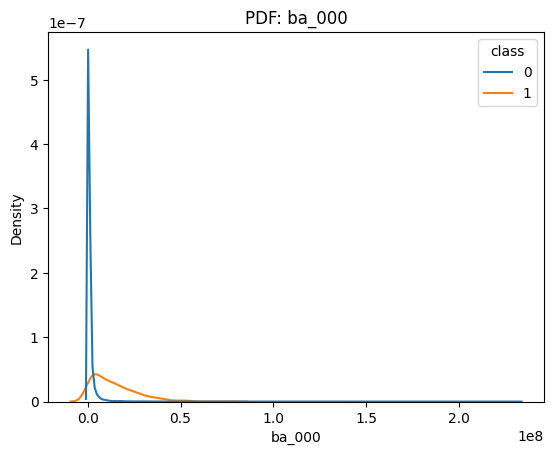

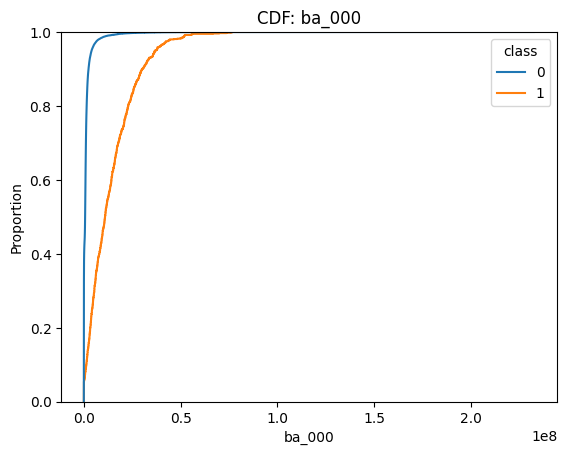

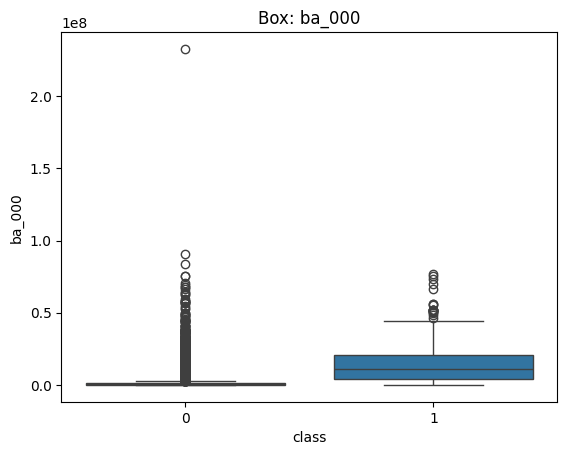

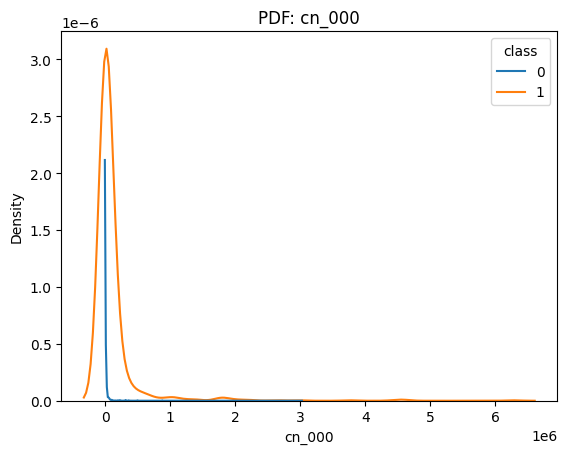

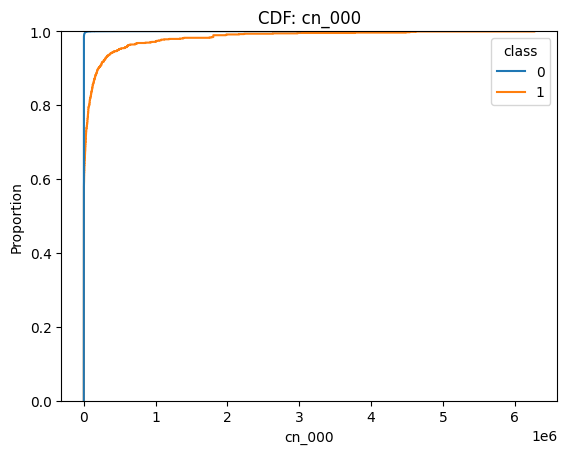

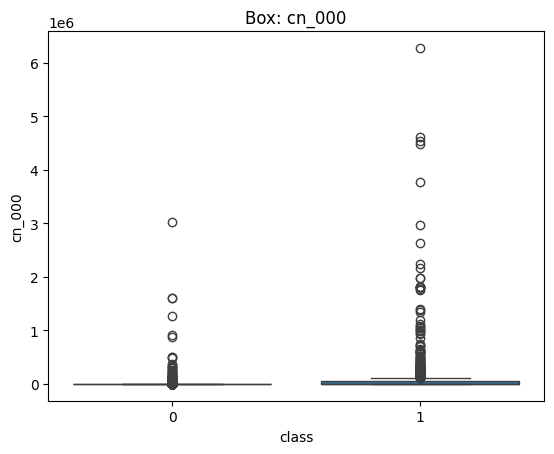

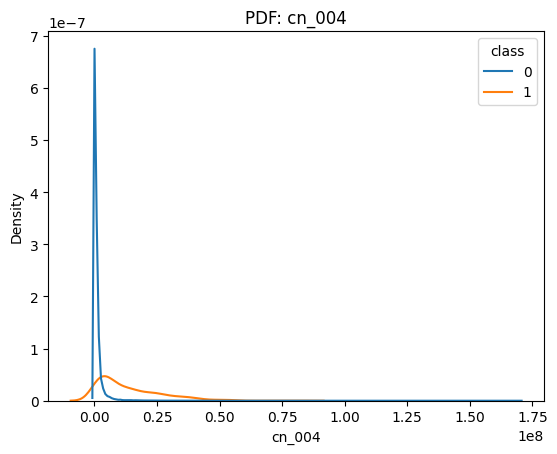

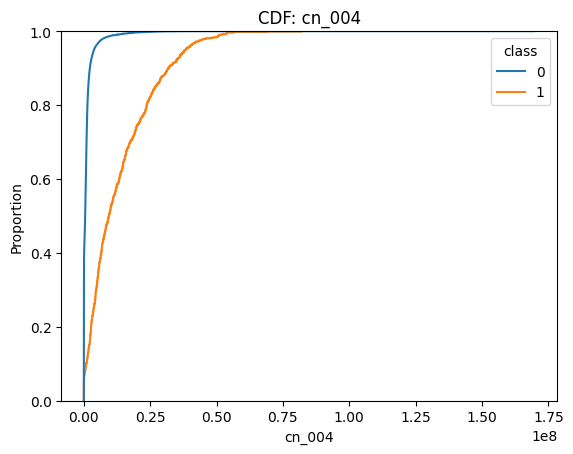

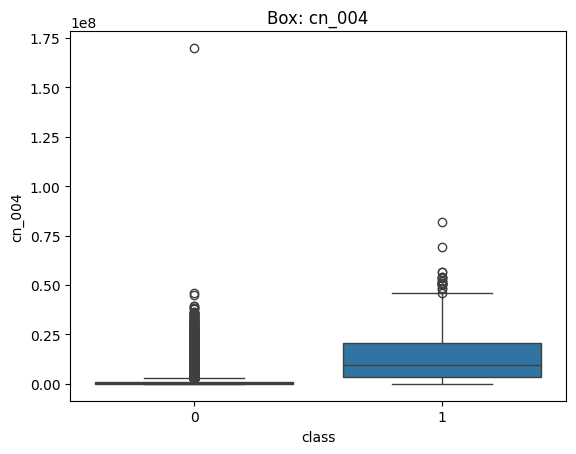

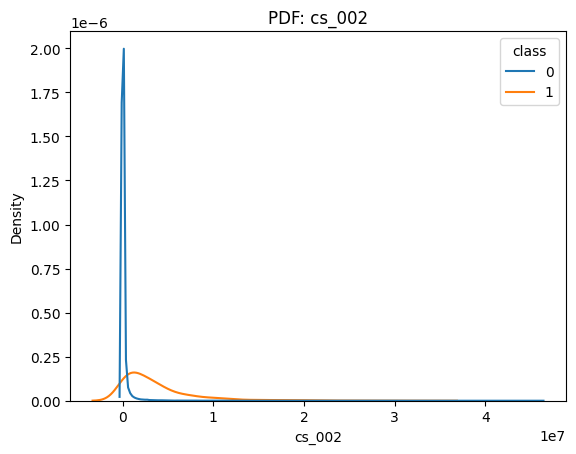

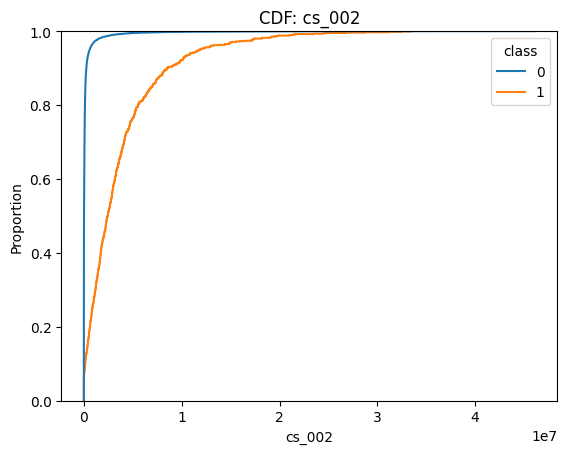

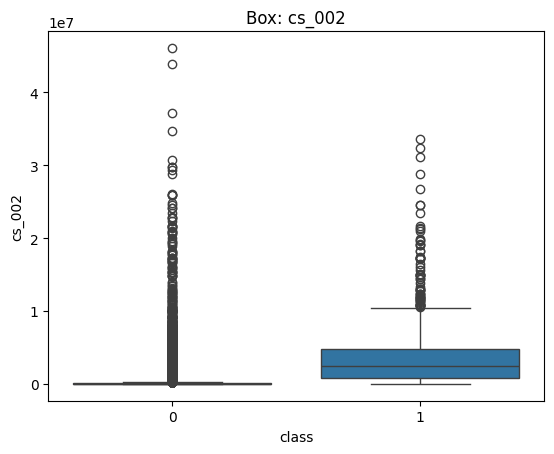

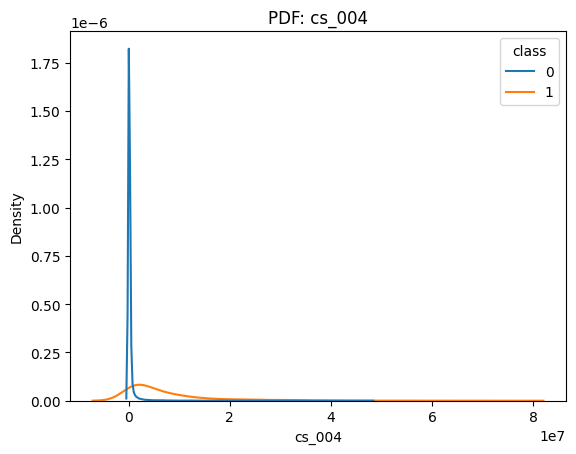

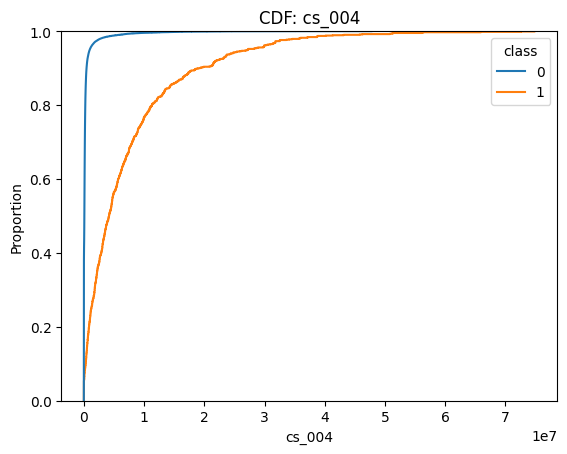

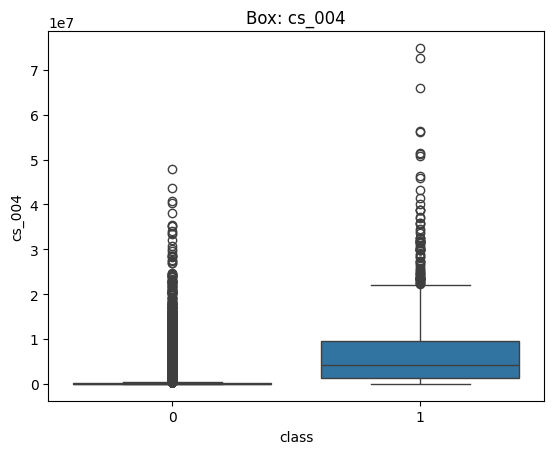

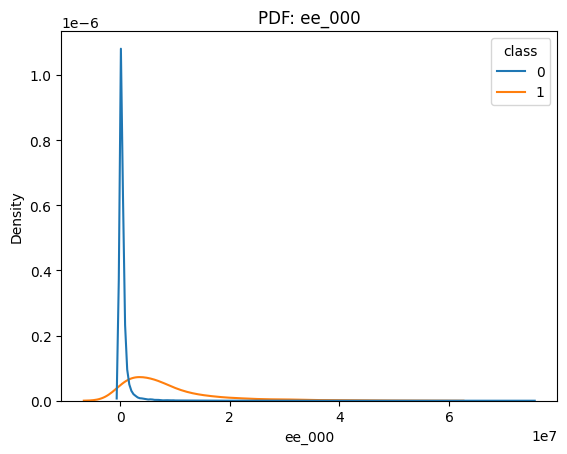

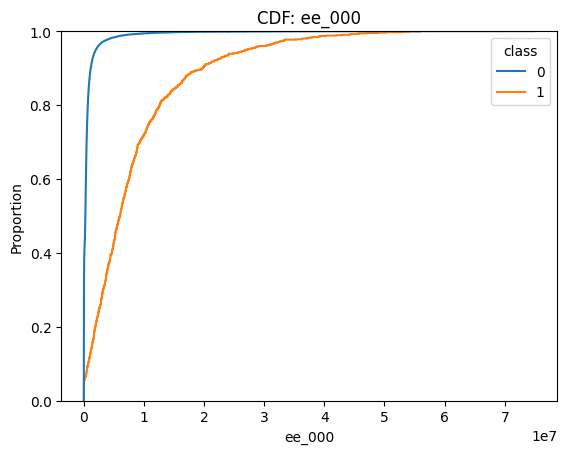

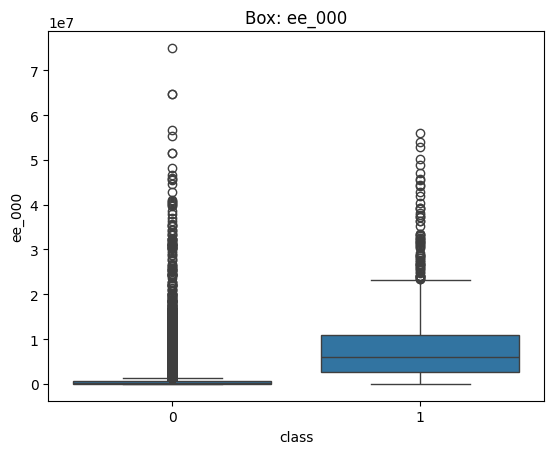

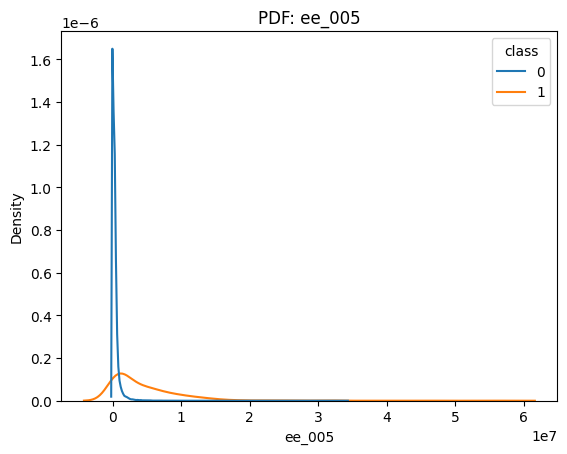

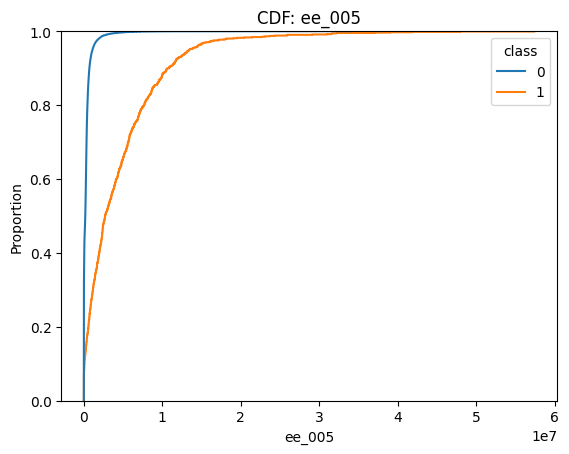

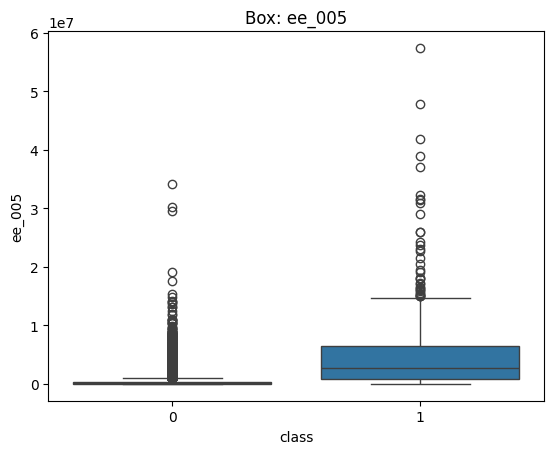

In [28]:
for c in top15_hist:
    sns.kdeplot(data=train_eda, x=c, hue="class", common_norm=False); plt.title(f"PDF: {c}"); plt.show()
    sns.ecdfplot(data=train_eda, x=c, hue="class"); plt.title(f"CDF: {c}"); plt.show()
    sns.boxplot(data=train_eda, x="class", y=c); plt.title(f"Box: {c}"); plt.show()


# I.VII Feature Reduction

In [29]:
from datetime import datetime
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, _tree
from warnings import simplefilter
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.style

# GLOBAL VARIABLES
RANDOM_NUMBER=42
TEST_SIZE_ASSIGNED = 0.20

In [30]:
def select_feature_dtc(X, Y):
    # get selector.threshold_
    selector = SelectFromModel(estimator=RandomForestClassifier(random_state=RANDOM_NUMBER)).fit(X, Y)
    print(f'selector.threshold_ = {selector.threshold_}')

    feature_name = X.columns[selector.get_support()]
    print(f'Number of selected features = {feature_name.shape[0]}')

    # put it into a data frame
    d = {'columns': X.columns.tolist(),  'support':selector.get_support()}
    df = pd.DataFrame(data=d)
    df = df[df.support ==True]
    df.reset_index(inplace = True, drop=True)
    print(f'Shape of Df = {df.shape}')
    return df, feature_name
best_feature,feature_name = select_feature_dtc(X_all, y_all)
print(f"Selected Features: {feature_name}")
X_dim = X_all[feature_name]
print("Reduced Dimension")
X_dim

selector.threshold_ = 0.006134969325153374
Number of selected features = 48
Shape of Df = (48, 2)
Selected Features: Index(['aa_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_006', 'ah_000',
       'ai_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000',
       'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_001', 'az_002',
       'ba_000', 'ba_004', 'ba_005', 'bb_000', 'bg_000', 'bh_000', 'bi_000',
       'bj_000', 'bk_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'cc_000',
       'ci_000', 'ck_000', 'cn_000', 'cn_001', 'cn_003', 'cn_004', 'cq_000',
       'cs_002', 'dn_000', 'ee_000', 'ee_004', 'ee_005', 'ee_007'],
      dtype='object')
Reduced Dimension


aa_000  ag_001  ag_002  ag_003   ag_004     ag_006     ah_000  ai_000  \
0       76698     0.0     0.0     0.0  37250.0  3664156.0  2551696.0     0.0   
1       33058     0.0     0.0     0.0  18254.0  1720800.0  1393352.0     0.0   
2       41040     0.0     0.0     0.0   1648.0  1883374.0  1234132.0     0.0   
3          12     0.0     0.0   318.0   2212.0     1872.0     2668.0     0.0   
4       60874     0.0     0.0     0.0  43752.0  1800340.0  1974038.0     0.0   
...       ...     ...     ...     ...      ...        ...        ...     ...   
59995  153002     0.0     0.0  2564.0  59100.0  6015982.0  4880368.0     0.0   
59996    2286     0.0     0.0     0.0    104.0    36564.0    56982.0     0.0   
59997     112     0.0     0.0     0.0     28.0    11538.0     8784.0     0.0   
59998   80292     0.0     0.0     0.0    330.0  3251010.0  2634394.0     0.0   
59999   40222     0.0     0.0     0.0   1226.0  1901140.0  1235850.0  1926.0   

       al_000    am_0  ...  cn_001    cn_003     cn_004      cq_000    cs_002  \
0         0.0     0.0  ...     0.0  118196.0  1309472.0   6700214.0  267998.0   
1         0.0     0.0  ...     0.0   98644.0  1179502.0   3646660.0  164860.0   
2         0.0     0.0  ...     0.0   33276.0  1215280.0   2673338.0   56362.0   
3       642.0  3894.0  ...    52.0    1894.0     2170.0     21614.0      24.0   
4         0.0     0.0  ...     0.0  378910.0  2497104.0   4289260.0   80950.0   
...       ...     ...  ...     ...       ...        ...         ...       ...   
59995  1224.0  2114.0  ...   860.0  404890.0  3156012.0  10845228.0  138036.0   
59996     0.0     0.0  ...     0.0   61572.0    63554.0    147638.0    3606.0   
59997     0.0     0.0  ...     0.0    3956.0    14690.0     43738.0      72.0   
59998     0.0     0.0  ...     0.0   11460.0   760936.0   6159728.0  333922.0   
59999     0.0     0.0  ...     0.0      32.0   497028.0   3076406.0   81228.0   

        dn_000     ee_000     ee_004     ee_005    ee_007  
0      62282.0   965866.0   721044.0   469792.0  157956.0  
1      33736.0   664504.0   293306.0   245416.0   81140.0  
2      13876.0   262032.0   423992.0   409564.0  158022.0  
3        232.0     5670.0       58.0       44.0       0.0  
4      44946.0   404740.0   405298.0   347188.0  311560.0  
...        ...        ...        ...        ...       ...  
59995  62846.0  1608808.0  1290398.0  1218244.0  717762.0  
59996   1066.0    13934.0    21126.0    68424.0       0.0  
59997    622.0    15876.0      452.0      144.0    2622.0  
59998  79230.0  1180714.0   347378.0   225724.0  165070.0  
59999  21454.0   409798.0   344546.0   254068.0  158304.0  

[58127 rows x 48 columns]

# I.IV Scaling & Stratified Split

In [29]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
target = "class"

X_train, X_val, y_train, y_val = train_test_split(
    X_dim, y_all,
    test_size=0.2,
    stratify=y_all,
    random_state=RANDOM_STATE
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
print(f"Class ratio (train): {y_train.mean():.4f}, (val): {y_val.mean():.4f}")

Train shape: (46501, 48), Validation shape: (11626, 48)
Class ratio (train): 0.0160, (val): 0.0160


# II.I Baseline Models

We’ll test **Logistic Regression, Random Forest, and LightGBM**, all run fast. 

Then we evaluate ROC-AUC and Expected cost.

We search for thresholds to minimize cost; also doing a 5-fold stratified CV Cost.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import numpy as np, pandas as pd

def evaluate_model(model, X_tr, y_tr, X_val, y_val, name="Model", cost_fp=10, cost_fn=500):
    y_proba = model.predict_proba(X_val)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)
    auc = roc_auc_score(y_val, y_proba)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    total_cost = fp*cost_fp + fn*cost_fn
    print(f"\n {name} ")
    print(f"AUC: {auc:.3f}")
    print(f"FP={fp}, FN={fn}, Cost={total_cost}")
    print(classification_report(y_val, y_pred, digits=3))
    return dict(model=name, auc=auc, cost=total_cost, fp=fp, fn=fn)

results = []

In [31]:
logreg = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
logreg.fit(X_train, y_train)
results.append(evaluate_model(logreg, X_train, y_train, X_val, y_val, "Logistic Regression"))


 Logistic Regression 
AUC: 0.832
FP=126, FN=87, Cost=44760
              precision    recall  f1-score   support

           0      0.992     0.989     0.991     11440
           1      0.440     0.532     0.482       186

    accuracy                          0.982     11626
   macro avg      0.716     0.761     0.736     11626
weighted avg      0.984     0.982     0.983     11626



In [32]:
rf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
results.append(evaluate_model(rf, X_train, y_train, X_val, y_val, "Random Forest"))


 Random Forest 
AUC: 0.991
FP=21, FN=60, Cost=30210
              precision    recall  f1-score   support

           0      0.995     0.998     0.996     11440
           1      0.857     0.677     0.757       186

    accuracy                          0.993     11626
   macro avg      0.926     0.838     0.877     11626
weighted avg      0.993     0.993     0.993     11626



In [33]:
lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=8, random_state=RANDOM_STATE)
lgbm.fit(X_train, y_train)
results.append(evaluate_model(lgbm, X_train, y_train, X_val, y_val, "LightGBM"))

[LightGBM] [Info] Number of positive: 743, number of negative: 45758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12045
[LightGBM] [Info] Number of data points in the train set: 46501, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015978 -> initscore=-4.120426
[LightGBM] [Info] Start training from score -4.120426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [34]:
pd.DataFrame(results)

model       auc   cost   fp  fn
0  Logistic Regression  0.831519  44760  126  87
1        Random Forest  0.990908  30210   21  60
2             LightGBM  0.992916  21150   15  42

The LightGBM performs best among parametric models tested.

**Why?**

- When we have Tabular + sparse & skewed features, tree ensembles like LightGBM shine. They are non-linear, robust to scale, handle wide ranges and monotonic relations. 

- Our feature filtering reduced noise; ensembles still model complex boundaries.

***Note***: The LightGBM “no further splits” warnings are common under extreme class skew and conservative split constraints. We can ease constraints later: min_data_in_leaf, num_leaves, feature_fraction


# II.II Cost-Tuned Threshold

Now we sweep the threshold to find the minimum-cost operating point.

In [35]:
from sklearn.metrics import roc_curve

def tune_threshold(model, X_val, y_val, cost_fp=10, cost_fn=500):
    prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, thr = roc_curve(y_val, prob)
    # cost = FP*cost_fp + FN*cost_fn
    fp = fpr * (1 - y_val.mean()) * len(y_val)
    fn = (1 - tpr) * y_val.mean() * len(y_val)
    costs = fp*cost_fp + fn*cost_fn
    best_idx = np.argmin(costs)
    best_thr = thr[best_idx]
    print(f"Best threshold: {best_thr:.3f}, Expected cost: {costs[best_idx]:.1f}")
    return best_thr, pd.DataFrame({"threshold": thr, "cost": costs})

In [36]:
best_thr_lr, cost_lr = tune_threshold(logreg, X_val, y_val)
best_thr_rf, cost_rf = tune_threshold(rf, X_val, y_val)
best_thr_lgbm, cost_lgbm = tune_threshold(lgbm, X_val, y_val)


Best threshold: 0.074, Expected cost: 34860.0
Best threshold: 0.015, Expected cost: 8380.0
Best threshold: 0.004, Expected cost: 6520.0


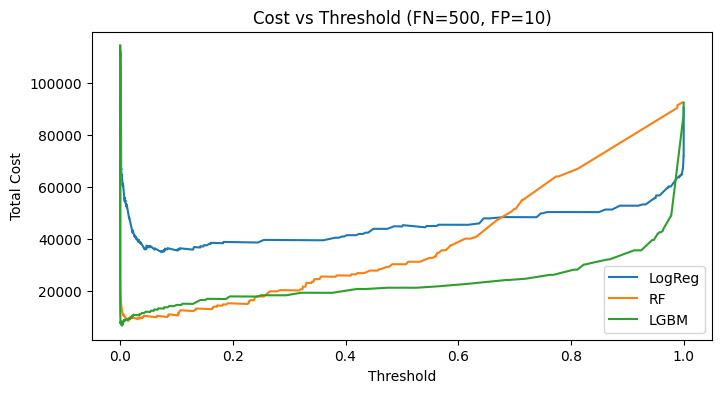

In [37]:
# Compare visually
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(cost_lr["threshold"], cost_lr["cost"], label="LogReg")
plt.plot(cost_rf["threshold"], cost_rf["cost"], label="RF")
plt.plot(cost_lgbm["threshold"], cost_lgbm["cost"], label="LGBM")
plt.xlabel("Threshold")
plt.ylabel("Total Cost")
plt.legend()
plt.title("Cost vs Threshold (FN=500, FP=10)")
plt.show()


In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

def cv_cost(
    model, X, y, *,
    cost_fp=10, cost_fn=500, folds=5, random_state=42,
    sampler=None,        # pass e.g. SMOTE(sampling_strategy=0.1, random_state=42)
    verbose=True
):
    y = np.asarray(y).ravel()
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)

    aucs, best_costs, best_thresholds = [], [], []

    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # optional resampling in-train only
        if sampler is not None:
            X_tr, y_tr = sampler.fit_resample(X_tr, y_tr)

        model.fit(X_tr, y_tr)
        prob = model.predict_proba(X_va)[:, 1]

        aucs.append(roc_auc_score(y_va, prob))

        fpr, tpr, thr = roc_curve(y_va, prob)
        P = (y_va == 1).sum()
        N = (y_va == 0).sum()
        FP = fpr * N
        FN = (1 - tpr) * P
        costs = cost_fp * FP + cost_fn * FN

        best_idx = np.argmin(costs)
        best_costs.append(costs[best_idx])
        best_thresholds.append(thr[best_idx])

    if verbose:
        print(f"Mean AUC = {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
        print(f"Mean Cost = {np.mean(best_costs):.1f} ± {np.std(best_costs):.1f}")
        print(f"Best thresholds per fold: {[round(t, 4) for t in best_thresholds]}")

    return {
        "aucs": aucs,
        "best_costs": best_costs,
        "best_thresholds": best_thresholds,
        "mean_auc": float(np.mean(aucs)),
        "mean_cost": float(np.mean(best_costs)),
    }


In [39]:
_ = cv_cost(lgbm, X_dim, y_all, cost_fp=10, cost_fn=500, folds=5)


[LightGBM] [Info] Number of positive: 743, number of negative: 45758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12057
[LightGBM] [Info] Number of data points in the train set: 46501, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015978 -> initscore=-4.120426
[LightGBM] [Info] Start training from score -4.120426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [40]:
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, classification_report

def evaluate_on_test(model, X_train, y_train, X_test, y_test, best_threshold=None):
    """
    Fits model on full training data and evaluates on test data.
    If best_threshold is provided, apply it to probabilities for cost-aware classification.
    """
    model.fit(X_train, y_train)
    prob = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, prob)
    print(f"\n[Test Evaluation] AUC = {auc:.3f}")

    if best_threshold is None:
        best_threshold = 0.5  # default
    y_pred = (prob >= best_threshold).astype(int)

    print(f"Threshold = {best_threshold:.3f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))
    
    # Optional: compute cost
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cost = 10 * fp + 500 * fn
    print(f"Total cost = {cost:.1f} (FP={fp}, FN={fn})")
    
    f1_macro = f1_score(y_test, y_pred, average="macro")
    return {"AUC": auc, "Macro-F1": f1_macro, "Cost": cost, "Threshold": best_threshold}

In [41]:
# Step 2 — Take median best threshold from folds
best_thr = np.median(_["best_thresholds"])

# Step 3 — Final test-set evaluation
final_metrics = evaluate_on_test(lgbm, X_all, y_all, x_test_pp, y_test, best_threshold=best_thr)
print(final_metrics)

[LightGBM] [Info] Number of positive: 929, number of negative: 57198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38193
[LightGBM] [Info] Number of data points in the train set: 58127, number of used features: 162
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015982 -> initscore=-4.120165
[LightGBM] [Info] Start training from score -4.120165

[Test Evaluation] AUC = 0.995
Threshold = 0.003
[[15247   378]
 [   10   365]]
              precision    recall  f1-score   support

           0      0.999     0.976     0.987     15625
           1      0.491     0.973     0.653       375

    accuracy                          0.976     16000
   macro avg      0.745     0.975     0.820     16000
weighted avg      0.987     0.976     0.980     16000

Total cost = 8780.0 (FP=378, FN=10)
{'AUC': 0.9954696533333334, 'Macro-F1': 0.8201938731757411, 'Co

- **Cost-sensitive decision thresholding** aligns model usage with business risk: heavy FN penalty pushes threshold down.
- **Stable CV shows generalization:** small variance in AUC and cost across folds.

# III Addressing Label Imbalance

The models (especially tree ensembles) already handle imbalance decently, but class imbalance still affects:

- how the model learns decision boundaries,

- how it estimates probabilities, and

- how stable cross-validation thresholds are.


### III.I Weighted Learning

In [42]:
logreg_weighted = LogisticRegression(class_weight={0:1, 1:59}, max_iter=500, solver='lbfgs')
rf_weighted     = RandomForestClassifier(class_weight={0:1, 1:59}, n_estimators=300, random_state=42)

In [43]:
_ = cv_cost(logreg, X_dim, y_all, cost_fp=10, cost_fn=500)

Mean AUC = 0.855 ± 0.011
Mean Cost = 33076.0 ± 2698.9
Best thresholds per fold: [0.0602, 0.0461, 0.0714, 0.0504, 0.0712]


Linear model underfits in this highly skewed dataset.

In [44]:
_ = cv_cost(logreg_weighted, X_dim, y_all, cost_fp=10, cost_fn=500)


Mean AUC = 0.964 ± 0.007
Mean Cost = 12138.0 ± 1147.5
Best thresholds per fold: [0.6747, 0.4474, 0.6108, 0.5298, 0.4041]


Reweighting fixed class prior mismatch and improved separation.

In [45]:
_ = cv_cost(rf, X_dim, y_all, cost_fp=10, cost_fn=500)

Mean AUC = 0.986 ± 0.004
Mean Cost = 8548.0 ± 1057.5
Best thresholds per fold: [0.1338, 0.0171, 0.0096, 0.0376, 0.043]


Already very strong.

In [46]:
_ = cv_cost(rf_weighted, X_dim, y_all, cost_fp=10, cost_fn=500)

Mean AUC = 0.987 ± 0.006
Mean Cost = 6850.0 ± 723.3
Best thresholds per fold: [0.0567, 0.04, 0.0167, 0.05, 0.03]


Small cost win (~12% better), big runtime hit.

In [47]:
from lightgbm import LGBMClassifier

# weight = N_neg / N_pos ≈ 59 
lgbm_weighted = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    min_data_in_leaf=50,
    scale_pos_weight=59,     # try 20–40 grid if you like
    random_state=RANDOM_NUMBER,
    n_jobs=-1
)

In [48]:
_ = cv_cost(lgbm_weighted, X_dim, y_all, cost_fp=10, cost_fn=500)


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 743, number of negative: 45758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12057
[LightGBM] [Info] Number of data points in the train set: 46501, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015978 -> initscore=-4.120426
[LightGBM] [Info] Start training from score -4.120426
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning

In [49]:
best_thr = np.median(_["best_thresholds"])

final_metrics = evaluate_on_test(lgbm_weighted, X_all, y_all, x_test_pp, y_test, best_threshold=best_thr)
print(final_metrics)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 929, number of negative: 57198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38185
[LightGBM] [Info] Number of data points in the train set: 58127, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015982 -> initscore=-4.120165
[LightGBM] [Info] Start training from score -4.120165
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50

[Test Evaluation] AUC = 0.996
Threshold = 0.000
[[15269   356]
 [   14   361]]
              precision    recall  f1-score   support

     

Slightly worse cost than just using cost-tuned thresholds. It seems that for tree ensembles, moderate weighting or even no weighting + cost-tuned threshold often suffices.

### III.II Sampling Approaches

In [50]:
import sklearn, imblearn
print("scikit-learn:", sklearn.__version__)
print("imbalanced-learn:", imblearn.__version__)


scikit-learn: 1.4.2
imbalanced-learn: 0.12.3


If we find true categoricals -> SMOTE-NC gets categorical indices and continuous features.

If not → we automatically switch to standard SMOTE on float64 arrays, so there’s no attempt to cast synthetic floats back to int64.

In [51]:
from imblearn.over_sampling import SMOTENC, SMOTE

def make_sampler(X_dim, pos_ratio=0.10, random_state=RANDOM_NUMBER):
    return SMOTE(
            sampling_strategy=pos_ratio,
            random_state=random_state,
            k_neighbors=5,
        )

In [52]:
sampler = make_sampler(X_dim, pos_ratio=0.10, random_state=RANDOM_NUMBER)

In [53]:
cat_cols = []
for c in X_dim.columns:
    vals = X_dim[c].dropna().unique()
    if len(vals) <= 5 or set(vals).issubset({0, 1}):
        cat_cols.append(c)

cat_idx = [X_dim.columns.get_loc(c) for c in cat_cols]

# 2) Ensure numeric dtypes without Pandas "Int64" (nullable)
#    -> use standard numpy dtypes: int64 for categoricals, float64 for continuous
cont_cols = [c for c in X_dim.columns if c not in cat_cols]

X_dim_fixed = X_dim.copy()
# Avoid pandas *nullable* integer dtypes; use numpy dtypes
X_dim_fixed[cont_cols] = X_dim_fixed[cont_cols].astype('float64')
if len(cat_cols) > 0:
    X_dim_fixed[cat_cols]  = X_dim_fixed[cat_cols].astype('int64')

# Ensure y is standard int
Y_fixed = pd.Series(np.asarray(y_all).ravel(), name='target').astype('int64')


In [54]:
_ = cv_cost(lgbm,X_dim_fixed, Y_fixed, sampler=sampler, cost_fp=10, cost_fn=500, folds=5, random_state=RANDOM_NUMBER)

[LightGBM] [Info] Number of positive: 4575, number of negative: 45758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 50333, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090895 -> initscore=-2.302760
[LightGBM] [Info] Start training from score -2.302760
[LightGBM] [Info] Number of positive: 4575, number of negative: 45758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 50333, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090895 -> initscore=-2.302760
[LightGBM] [Info] Start training from score -2.302760
[LightGBM] [

In [55]:
# Inspect how many positives per fold to keep k_neighbors safe (>= k+1)
# (With ~800 pos overall, ~160 per fold; k=5 is fine.)
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for _, va_idx in skf.split(X_dim_fixed, Y_fixed):
    print("Positives in fold:", int(Y_fixed.iloc[va_idx].sum()))


Positives in fold: 186
Positives in fold: 186
Positives in fold: 185
Positives in fold: 186
Positives in fold: 186


# IV.I Root Cause Analysis & Explainability